Problematica 
Análisis de tendencias musicales a lo largo de los años.
Queremos analizar cómo ha evolucionado la popularidad de la música en diferentes géneros y cómo algunas características como la energía, bailabilidad, acústica y loudness han cambiado a lo largo de los años. A través de este análisis, se busca entender cómo los gustos musicales han cambiado y qué características de las canciones se correlacionan más con la popularidad a lo largo del tiempo.


In [32]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import json
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from datetime import datetime

Código principla: ElasticSearchProvider.
Este código sirve para conectarse a un servidor llamado Elasticsearch que está en tu computadora. Su función principal es leer un archivo de texto donde cada línea tiene datos en formato JSON (por ejemplo, información de canciones) y luego guardar todos esos datos en una especie de base de datos llamada "spotify-insights". Lo hace todo de forma rápida y automática. Además, cuando termina de cargar los datos, cierra la conexión con el servidor para no dejarla abierta. Es útil si tienes muchos datos y quieres guardarlos en un lugar donde luego puedas buscarlos fácilmente.

In [2]:
class ElasticSearchProvider:

    def __init__(self):
        self.host = "http://localhost:9200"
        #self.user = str(user)
        #self.password = str(password)
        self.index = "spotify-insights"
        self.index_type ="_doc"
        self.connection = Elasticsearch(self.host)

    def __enter__(self):
        try:
            self.connection=Elasticsearch(self.host)
            return self
        except Exception as e:
            return{
                "StatusCode":500,
                "body":json.dumps({
                    "Message":str(e)
                })
            }

    def __exit__(self, exception_type, exception_value, traceback):
        self.connection.transport.close()


Lista de consultas


1.- Top 10 canciones más populares por género:

In [3]:
def showMostPopularbyGenre(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 0,
                    "aggs": {
                        "top_genres": {
                        "terms": {
                            "field": "genre",
                            "size": 10
                        },
                        "aggs": {
                            "top_tracks": {
                            "top_hits": {
                                "size": 10,
                                "_source": ["track_name", "artist_name", "popularity"]
                                }
                            }
                        }
                    }
                }
            }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")

ElasticSearchProvider.showMostPopularbyGenre=showMostPopularbyGenre

In [ ]:
data = response['aggregations']['top_genres']['buckets']
n_genres = len(data)
cols = 3  # Columnas en el grid
rows = int(np.ceil(n_genres / cols))  # Filas necesarias

fig = plt.figure(figsize=(20, 5*rows), constrained_layout=True)
fig.suptitle('Popularidad de Tracks por Género Musical', fontsize=16, y=1.05)

for i, genre in enumerate(data, 1):
    genre_name = genre['key']
    tracks = genre['top_tracks']['hits']['hits'][:10]  # Top 5 tracks por género
    
    track_names = [f"{t['_source']['track_name'][:15]}..." for t in tracks]
    popularities = [t['_source']['popularity'] for t in tracks]
    ax = fig.add_subplot(rows, cols, i)

    wedges, texts, autotexts = ax.pie(
        popularities,
        labels=track_names,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 8}
    )
    
    ax.set_title(f"{genre_name.title()}\n({genre['doc_count']} tracks)", fontsize=10)
plt.tight_layout()
plt.show()

KeyError: 'aggregations'

2.- Top 5 canciones más populares de un artista específico.

In [23]:
def showMostPopularbyArtist(self,name):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 5,
                    "query": {
                        "match": {
                        "artist_name": name 
                        }
                    },
                    "aggs": {
                        "top_tracks": {
                        "terms": {
                            "field": "track_name.keyword",  
                        },
                        "aggs": {
                            "popular_tracks": {
                            "top_hits": {
                                "size": 5,
                                "_source": ["track_name", "popularity"]
                            }
                            }
                        }
                        }
                    }
                }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
            
ElasticSearchProvider.showMostPopularbyArtist=showMostPopularbyArtist

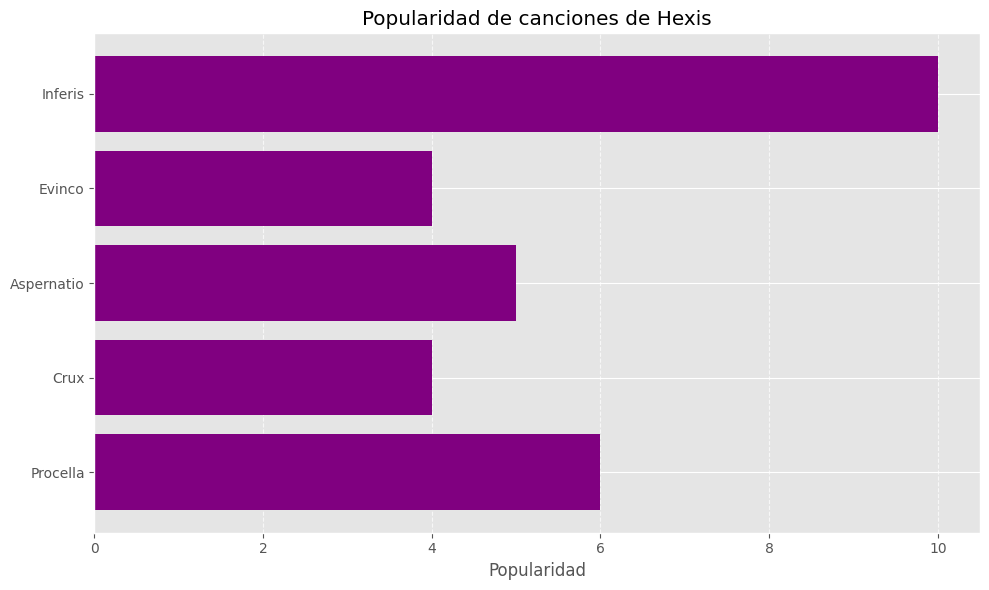

In [ ]:
provider = ElasticSearchProvider()
name="Hexis"
response = provider.showMostPopularbyArtist(name)

if response:
    print("Respuesta obtenida:")
    print(response)

    # Extraer los datos
    hits = response["hits"]["hits"]

    # Listas para nombres de canciones y su popularidad
    canciones = []
    popularidades = []

    for hit in hits:
        source = hit["_source"]
        track_name = source.get("track_name", "Desconocido")
        popularity = source.get("popularity", 0)

        canciones.append(track_name)
        popularidades.append(popularity)

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.barh(canciones, popularidades, color='purple')
    plt.xlabel('Popularidad')
    plt.title(f'Popularidad de canciones de {name}')
    plt.gca().invert_yaxis()  # Para que la canción más popular quede arriba
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

else:
    print("No se obtuvo respuesta válida.")


3.-Promedio de la popularidad por año.

In [27]:
def showMostPopularGenrebyYear(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 0,
                    "aggs": {
                        "avg_popularity_by_genre": {
                        "terms": {
                            "field": "genre",
                            "size": 20
                        },
                        "aggs": {
                            "avg_popularity": {
                            "avg": {
                                "field": "popularity"
                            }
                            }
                        }
                        }
                    }
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")

ElasticSearchProvider.showMostPopularGenrebyYear=showMostPopularGenrebyYear

Respuesta obtenida:
{'took': 278, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'avg_popularity_by_genre': {'doc_count_error_upper_bound': 0, 'sum_other_doc_count': 764097, 'buckets': [{'key': 'black-metal', 'doc_count': 21852, 'avg_popularity': {'value': 11.089968881566904}}, {'key': 'gospel', 'doc_count': 21621, 'avg_popularity': {'value': 18.92040146154202}}, {'key': 'ambient', 'doc_count': 21389, 'avg_popularity': {'value': 20.008742811725654}}, {'key': 'acoustic', 'doc_count': 21097, 'avg_popularity': {'value': 17.825093615205954}}, {'key': 'alt-rock', 'doc_count': 20918, 'avg_popularity': {'value': 38.59680657806674}}, {'key': 'emo', 'doc_count': 20845, 'avg_popularity': {'value': 23.661981290477332}}, {'key': 'indian', 'doc_count': 20583, 'avg_popularity': {'value': 8.790458145071176}}, {'key': 'k-pop', 'doc_count': 20004, 'avg_popula

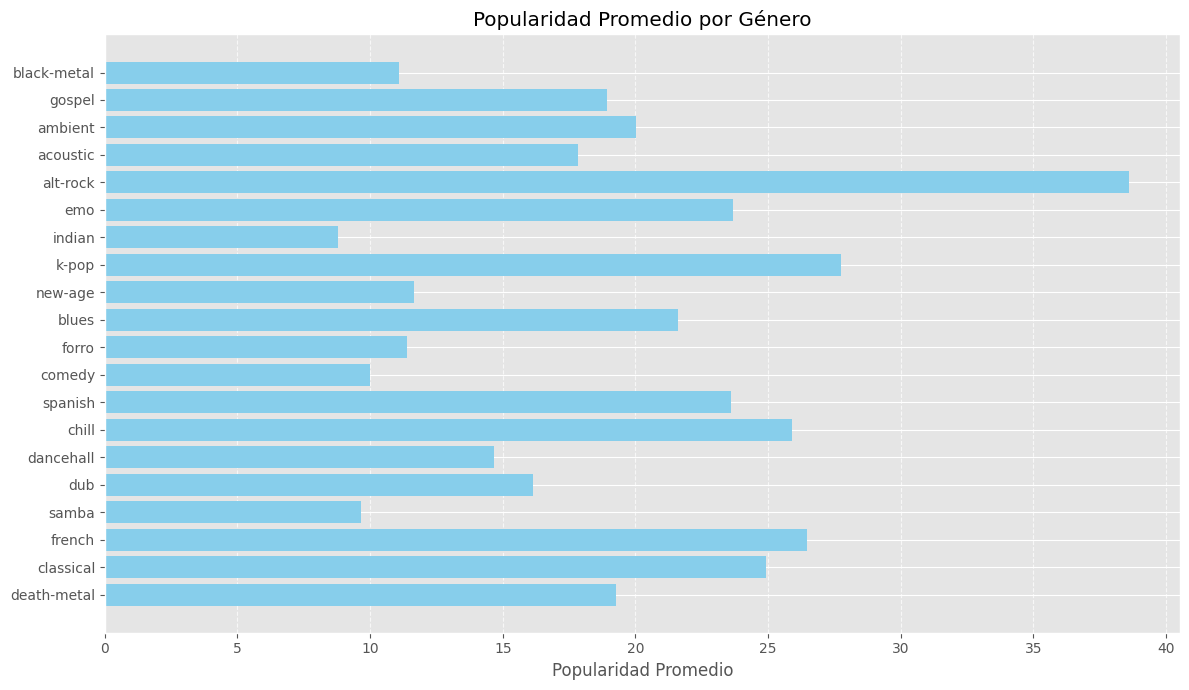

In [ ]:
provider = ElasticSearchProvider()

response = provider.showMostPopularGenrebyYear()
if response:
    # Extraer datos de la respuesta
    buckets = response["aggregations"]["avg_popularity_by_genre"]["buckets"]

    # Listas para géneros y popularidad promedio
    generos = []
    popularidad_promedio = []

    for bucket in buckets:
        generos.append(bucket["key"])
        popularidad_promedio.append(bucket["avg_popularity"]["value"])

    # Graficar
    plt.figure(figsize=(12, 7))
    plt.barh(generos, popularidad_promedio, color='skyblue')
    plt.xlabel('Popularidad Promedio')
    plt.title('Popularidad Promedio por Género')
    plt.gca().invert_yaxis()  # Géneros más populares arriba
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

else:
    print("No se obtuvo respuesta válida.")

4.-Top 5 géneros más populares en un año específico.

In [29]:
def showMostPopularGenrebySpecificYear(self,year):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 0,
                    "query": {
                        "term": {
                        "year": year
                        }
                    },
                    "aggs": {
                        "top_genres": {
                        "terms": {
                            "field": "genre",
                            "size": 5
                        },
                        "aggs": {
                            "avg_popularity": {
                            "avg": {
                                "field": "popularity"
                            }
                            }
                        }
                        }
                    }
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
ElasticSearchProvider.showMostPopularGenrebySpecificYear=showMostPopularGenrebySpecificYear

C:\Users\Manuel\AppData\Local\Temp\ipykernel_14424\3129274600.py:17: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  year_readable = datetime.utcfromtimestamp(year / 1000).strftime('%Y')


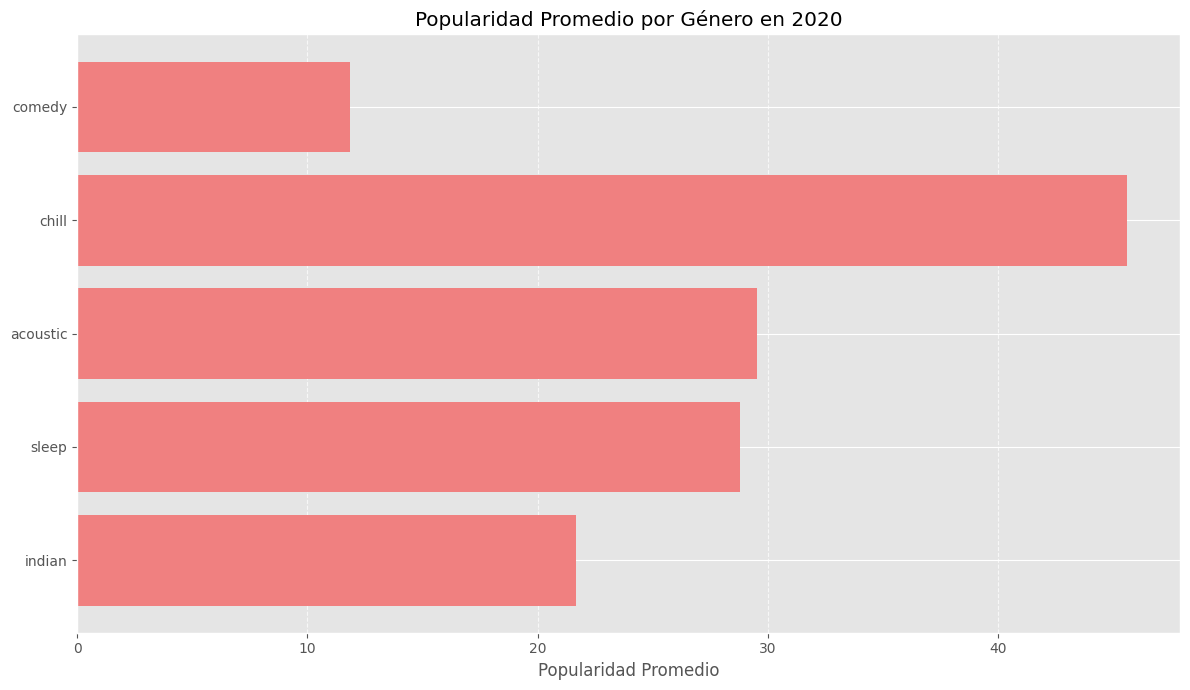

In [33]:
provider = ElasticSearchProvider()
year=1577836800000
response = provider.showMostPopularGenrebySpecificYear(year)
if response:
    # Extraer datos de la respuesta
    buckets = response["aggregations"]["top_genres"]["buckets"]

    # Listas para géneros y popularidad promedio
    generos = []
    popularidad_promedio = []

    for bucket in buckets:
        generos.append(bucket["key"])
        popularidad_promedio.append(bucket["avg_popularity"]["value"])

    # Convertir el timestamp a un año legible
    year_readable = datetime.utcfromtimestamp(year / 1000).strftime('%Y')

    # Graficar
    plt.figure(figsize=(12, 7))
    plt.barh(generos, popularidad_promedio, color='lightcoral')
    plt.xlabel('Popularidad Promedio')
    plt.title(f'Popularidad Promedio por Género en {year_readable}')
    plt.gca().invert_yaxis()  # Géneros más populares arriba
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

else:
    print("No se obtuvo respuesta válida.")

5.-Top 10 canciones con la mayor energía.

In [34]:
def showSongsWhittheMostEnegy(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 0,
                    "aggs": {
                        "top_energy_songs": {
                        "top_hits": {
                            "size": 10,
                            "_source": ["track_name", "artist_name", "energy"],
                            "sort": [
                            {
                                "energy": {
                                "order": "desc"
                                }
                            }
                            ]
                        }
                        }
                    }
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
            
ElasticSearchProvider.showSongsWhittheMostEnegy=showSongsWhittheMostEnegy

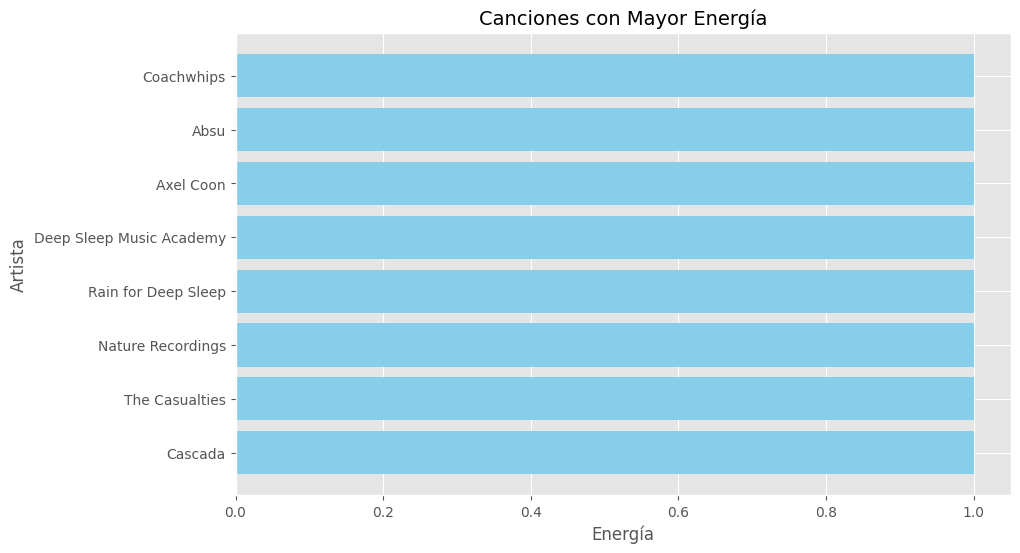

In [36]:
provider = ElasticSearchProvider()
response = provider.showSongsWhittheMostEnegy()
if response:
    songs = response["aggregations"]["top_energy_songs"]["hits"]["hits"]

    # Obtener los artistas, canciones y energía
    artists = [song["_source"]["artist_name"] for song in songs]
    tracks = [song["_source"]["track_name"] for song in songs]
    energies = [song["_source"]["energy"] for song in songs]

    # Paso 2: Crear la gráfica con matplotlib
    plt.figure(figsize=(10, 6))

    # Crear barras horizontales para representar la energía
    plt.barh(artists, energies, color='skyblue')

    # Agregar título y etiquetas
    plt.title('Canciones con Mayor Energía', fontsize=14)
    plt.xlabel('Energía', fontsize=12)
    plt.ylabel('Artista', fontsize=12)

    # Mostrar el gráfico
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

6-. Top 10 canciones más "acústicas".

In [37]:
def showSongsWhitMostAcustic(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 0,
                    "aggs": {
                        "top_acoustic_songs": {
                        "top_hits": {
                            "size": 10,
                            "_source": ["track_name", "artist_name", "acousticness"],
                            "sort": [
                            {
                                "acousticness": {
                                "order": "desc"
                                }
                            }
                            ]
                        }
                        }
                    }
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
ElasticSearchProvider.showSongsWhitMostAcustic=showSongsWhitMostAcustic

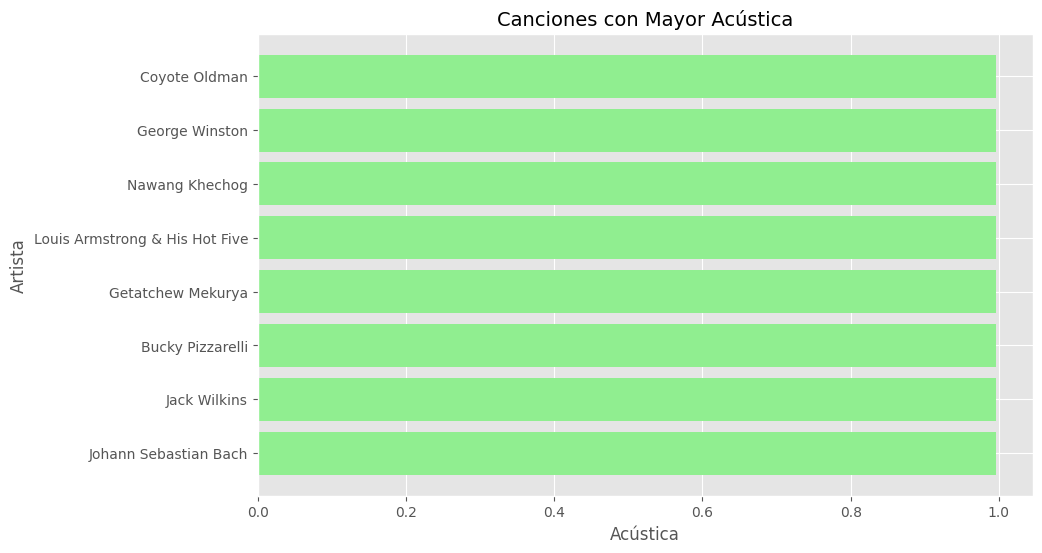

In [39]:
provider = ElasticSearchProvider()
response = provider.showSongsWhitMostAcustic()
if response:
    songs = response["aggregations"]["top_acoustic_songs"]["hits"]["hits"]

    # Obtener los artistas, canciones y acousticness
    artists = [song["_source"]["artist_name"] for song in songs]
    tracks = [song["_source"]["track_name"] for song in songs]
    acousticness_values = [song["_source"]["acousticness"] for song in songs]

    # Paso 2: Crear la gráfica con matplotlib
    plt.figure(figsize=(10, 6))

    # Crear barras horizontales para representar la acousticness
    plt.barh(artists, acousticness_values, color='lightgreen')

    # Agregar título y etiquetas
    plt.title('Canciones con Mayor Acústica', fontsize=14)
    plt.xlabel('Acústica', fontsize=12)
    plt.ylabel('Artista', fontsize=12)

    # Mostrar el gráfico
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

7.- Promedio de "valence" por año.

In [40]:
def showPromValencebyYear(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 0,
                    "aggs": {
                        "avg_valence_by_year": {
                        "terms": {
                            "field": "year",
                            "size": 10000  
                        },
                        "aggs": {
                            "avg_valence": {
                            "avg": {
                                "field": "valence"
                            }
                            }
                        }
                        }
                    }
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
            
ElasticSearchProvider.showPromValencebyYear=showPromValencebyYear

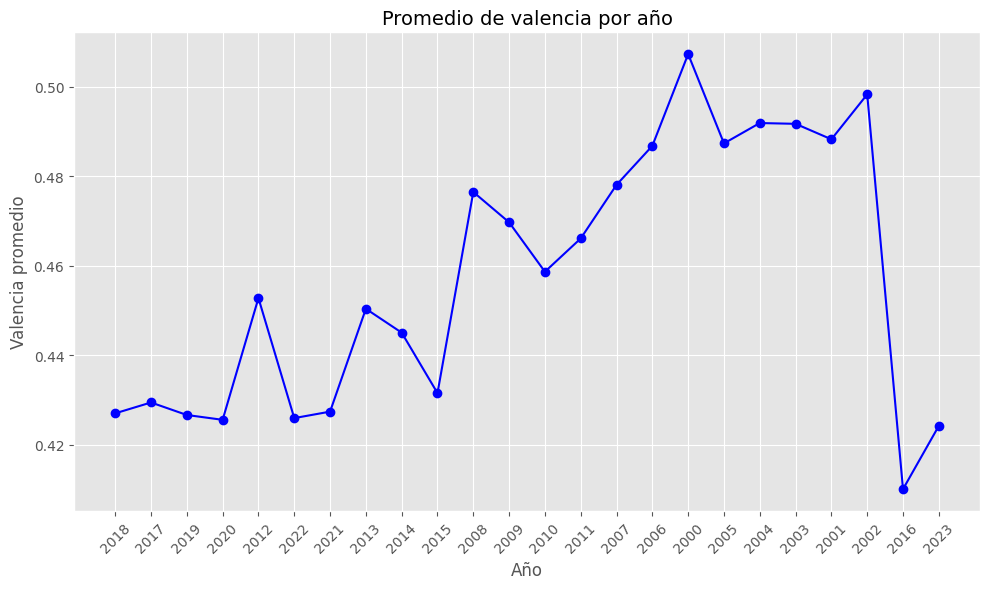

In [42]:
provider = ElasticSearchProvider()
response = provider.showPromValencebyYear()
if response:
    years = [bucket['key_as_string'] for bucket in response['aggregations']['avg_valence_by_year']['buckets']]
    valence_values = [bucket['avg_valence']['value'] for bucket in response['aggregations']['avg_valence_by_year']['buckets']]

    # Crear la gráfica
    plt.figure(figsize=(10, 6))
    plt.plot(years, valence_values, marker='o', linestyle='-', color='b')

    # Configurar etiquetas y título
    plt.title('Promedio de valencia por año', fontsize=14)
    plt.xlabel('Año', fontsize=12)
    plt.ylabel('Valencia promedio', fontsize=12)

    # Girar las etiquetas del eje x para mejorar la visibilidad
    plt.xticks(rotation=45)

    # Mostrar la gráfica
    plt.tight_layout()
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

8.- Distribución de las canciones por "mode" (mayoría mayor o menor).

In [43]:
def showModebySongs(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 0,
                    "aggs": {
                        "mode_distribution": {
                        "terms": {
                            "field": "mode",
                            "size": 10
                        },
                        "aggs": {
                            "count_by_mode": {
                            "value_count": {
                                "field": "mode"
                            }
                            }
                        }
                        }
                    }
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")

ElasticSearchProvider.showModebySongs=showModebySongs

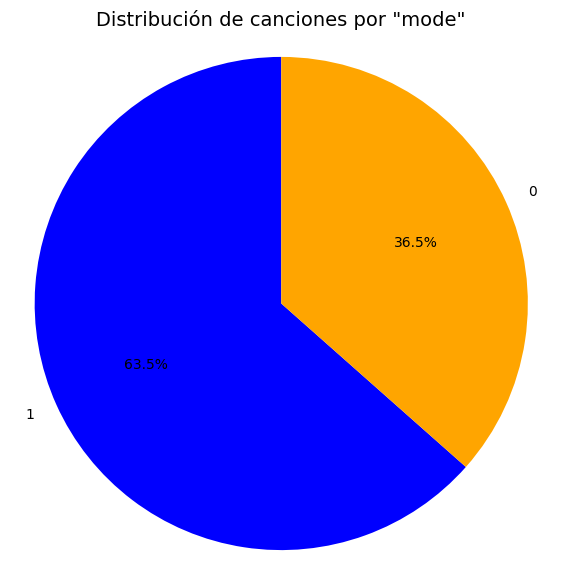

In [46]:
provider = ElasticSearchProvider()
response = provider.showModebySongs()
if response:
# Extraer los "mode" y las cantidades de canciones
    # Extraer los "mode" y las cantidades de canciones
    modes = [bucket['key'] for bucket in response['aggregations']['mode_distribution']['buckets']]
    song_counts = [bucket['doc_count'] for bucket in response['aggregations']['mode_distribution']['buckets']]

    # Crear la gráfica de pastel
    plt.figure(figsize=(7, 7))
    plt.pie(song_counts, labels=modes, autopct='%1.1f%%', colors=['blue', 'orange'], startangle=90)

    # Título
    plt.title('Distribución de canciones por "mode"', fontsize=14)

    # Mostrar la gráfica
    plt.axis('equal')  # Para que el gráfico sea un círculo perfecto
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

9.- Promedio de duración de canciones por género.

In [47]:
def showDurationBySongs(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 0,
                    "aggs": {
                        "genres": {
                        "terms": {
                            "field": "genre",  
                            "size": 20
                        },
                        "aggs": {
                            "avg_duration": {
                            "avg": {
                                "field": "duration_ms" 
                            }
                            }
                        }
                        }
                    }
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
            
ElasticSearchProvider.showDurationBySongs=showDurationBySongs

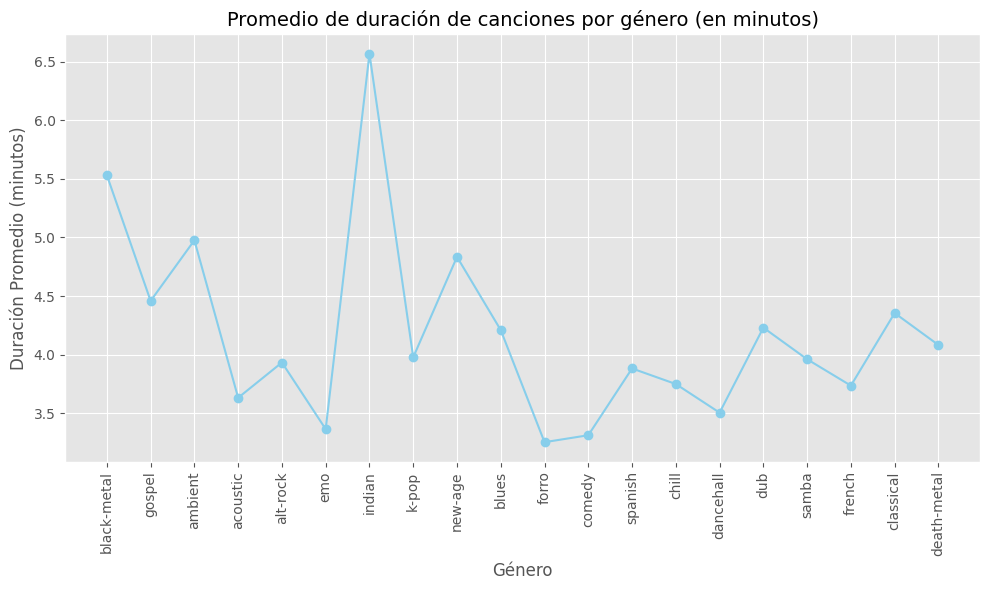

In [50]:
provider = ElasticSearchProvider()
response = provider.showDurationBySongs()
if response:
    genres = [bucket['key'] for bucket in response['aggregations']['genres']['buckets']]
    durations = [bucket['avg_duration']['value'] for bucket in response['aggregations']['genres']['buckets']]

    # Convertir la duración de milisegundos a minutos
    durations_minutes = [duration / 60000 for duration in durations]

    # Crear el gráfico de puntos conectados con una línea
    plt.figure(figsize=(10, 6))

    # Graficar los puntos
    plt.plot(genres, durations_minutes, marker='o', linestyle='-', color='skyblue')

    # Configurar etiquetas y título
    plt.title('Promedio de duración de canciones por género (en minutos)', fontsize=14)
    plt.xlabel('Género', fontsize=12)
    plt.ylabel('Duración Promedio (minutos)', fontsize=12)

    # Rotar las etiquetas del eje X para mejor visibilidad
    plt.xticks(rotation=90)

    # Mostrar la gráfica
    plt.tight_layout()
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

10.- Top 10 canciones más "loud".

In [51]:
def showSongsWhitMostLoud(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 10,
                    "sort": [
                        {
                        "loudness": {
                            "order": "desc"  
                        }
                        }
                    ],
                    "_source": ["track_name", "artist_name", "loudness"]  
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
            
ElasticSearchProvider.showSongsWhitMostLoud=showSongsWhitMostLoud

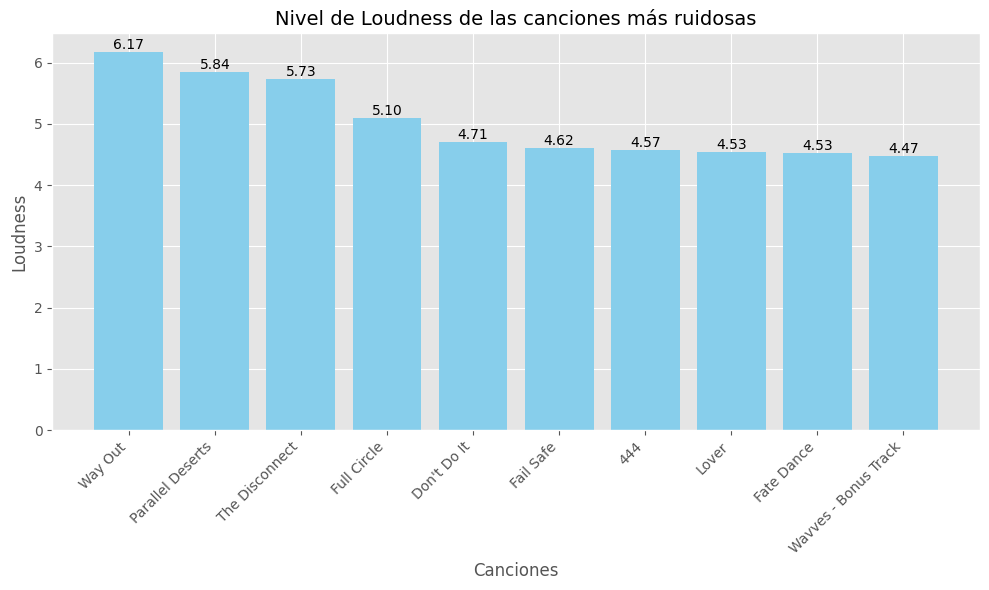

In [55]:
provider = ElasticSearchProvider()
response = provider.showSongsWhitMostLoud()
if response:
    # Extraer las canciones, los artistas y la loudness
    songs = [hit['_source']['track_name'] for hit in response['hits']['hits']]
    artists = [hit['_source']['artist_name'] for hit in response['hits']['hits']]
    loudness = [hit['_source']['loudness'] for hit in response['hits']['hits']]

    # Crear el gráfico de barras verticales
    plt.figure(figsize=(10, 6))
    bars = plt.bar(songs, loudness, color='skyblue')

    # Añadir etiquetas y título
    plt.title('Nivel de Loudness de las canciones más ruidosas', fontsize=14)
    plt.xlabel('Canciones', fontsize=12)
    plt.ylabel('Loudness', fontsize=12)
    plt.xticks(rotation=45, ha='right')  # Rota las etiquetas del eje X para que se vean mejor

    # Añadir los valores de loudness sobre las barras
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                f'{bar.get_height():.2f}', va='bottom', ha='center', fontsize=10)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

11.-Top 10 canciones con mayor "speechiness".

In [56]:
def showSongsWhitMostSpeech(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 10,
                    "sort": [
                        {
                        "speechiness": {
                            "order": "desc"  
                        }
                        }
                    ],
                    "_source": ["track_name", "artist_name", "speechiness"] 
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
            
ElasticSearchProvider.showSongsWhitMostSpeech=showSongsWhitMostSpeech

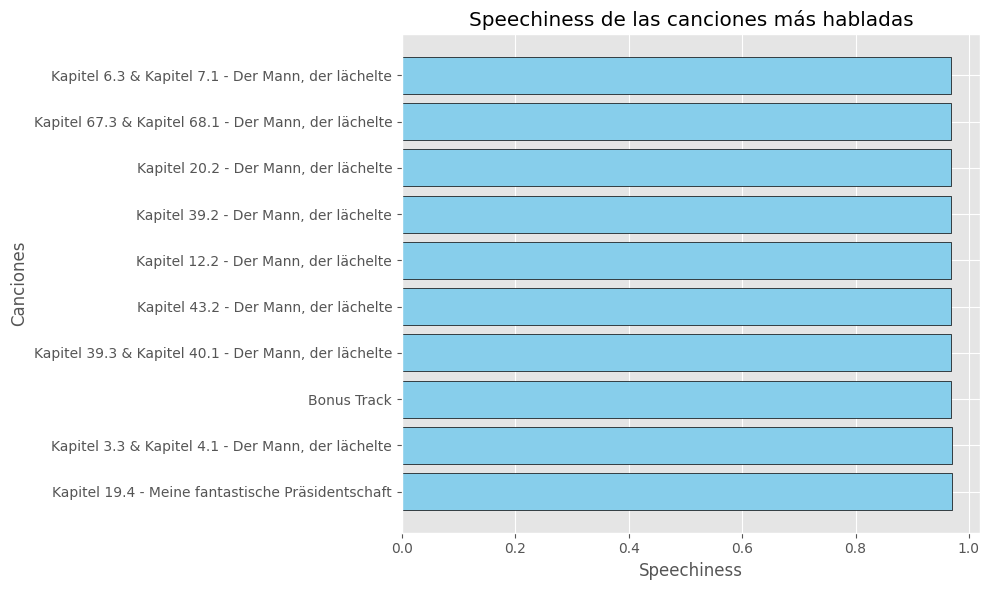

In [59]:
provider = ElasticSearchProvider()
response = provider.showSongsWhitMostSpeech()
if response:

    # Extraer los nombres de las canciones y la speechiness
    songs = [hit['_source']['track_name'] for hit in response['hits']['hits']]
    speechiness = [hit['_source']['speechiness'] for hit in response['hits']['hits']]

    # Crear el gráfico de barras horizontal
    plt.figure(figsize=(10, 6))
    plt.barh(songs, speechiness, color='skyblue', edgecolor='black')

    # Añadir etiquetas y título
    plt.xlabel('Speechiness')
    plt.ylabel('Canciones')
    plt.title('Speechiness de las canciones más habladas')

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

12.-Distribución de los valores de "time_signature".

In [60]:
def showTimeSignature(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 0,
                    "aggs": {
                        "time_signature_distribution": {
                        "terms": {
                            "field": "time_signature",
                            "size": 5  
                        }
                        }
                    }
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
            
ElasticSearchProvider.showTimeSignature=showTimeSignature

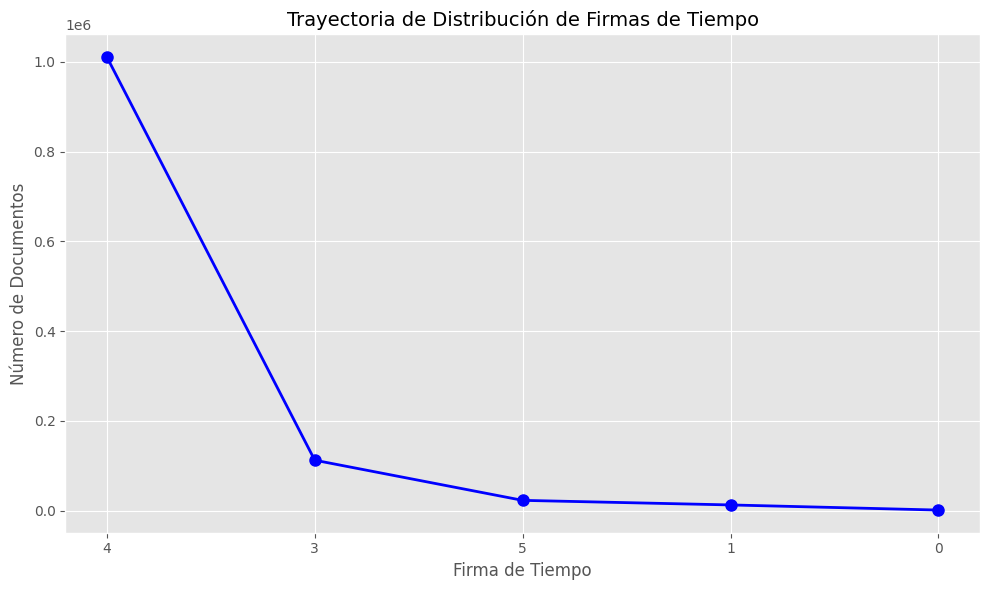

In [65]:
provider = ElasticSearchProvider()
response = provider.showTimeSignature()
if response:
    # Extraer las firmas de tiempo y los recuentos de documentos
    time_signatures = [bucket['key'] for bucket in response['aggregations']['time_signature_distribution']['buckets']]
    doc_counts = [bucket['doc_count'] for bucket in response['aggregations']['time_signature_distribution']['buckets']]

    # Crear el gráfico de trayectoria
    plt.figure(figsize=(10, 6))
    plt.plot(time_signatures, doc_counts, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)

    # Añadir título y etiquetas
    plt.title('Trayectoria de Distribución de Firmas de Tiempo', fontsize=14)
    plt.xlabel('Firma de Tiempo', fontsize=12)
    plt.ylabel('Número de Documentos', fontsize=12)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.grid(True)
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

13.-Top 10 canciones con mayor "instrumentalness".

In [66]:
def showInstrumental(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 10,
                    "sort": [
                        {
                        "instrumentalness": {
                            "order": "desc"
                        }
                        }
                    ],
                    "_source": ["track_name", "artist_name", "instrumentalness"]
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")

ElasticSearchProvider.showInstrumental=showInstrumental

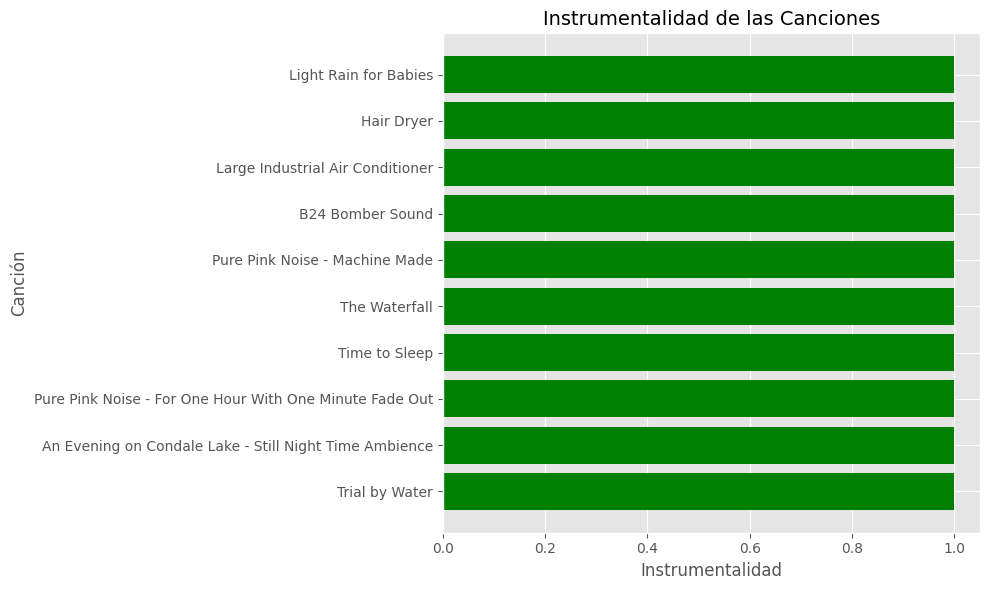

In [68]:
provider = ElasticSearchProvider()
response = provider.showInstrumental()
if response:
    # Extraer los nombres de las canciones
    track_names = [hit['_source']['track_name'] for hit in response['hits']['hits']]
    instrumentalness = [hit['_source']['instrumentalness'] for hit in response['hits']['hits']]

    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.barh(track_names, instrumentalness, color='green')

    # Añadir título y etiquetas
    plt.title('Instrumentalidad de las Canciones', fontsize=14)
    plt.xlabel('Instrumentalidad', fontsize=12)
    plt.ylabel('Canción', fontsize=12)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

14.- Las 10 canciones mas populares 

In [69]:
def showMorePopularitySongs(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 10,
                    "sort": [
                        {
                        "popularity": {
                            "order": "desc"
                        }
                        }
                    ],
                    "_source": ["track_name", "artist_name", "popularity"]
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
            
ElasticSearchProvider.showMorePopularitySongs=showMorePopularitySongs

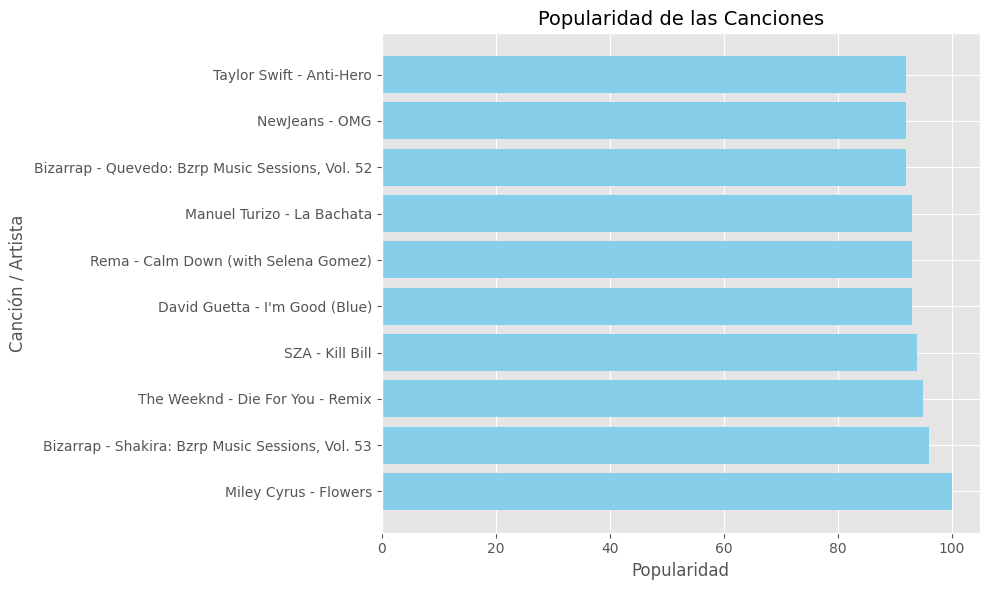

In [71]:
provider = ElasticSearchProvider()
response = provider.showMorePopularitySongs()
if response:
    # Extraer los nombres de las canciones y su popularidad
    track_names = [f"{hit['_source']['artist_name']} - {hit['_source']['track_name']}" for hit in response['hits']['hits']]
    popularity = [hit['_source']['popularity'] for hit in response['hits']['hits']]

    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.barh(track_names, popularity, color='skyblue')

    # Añadir título y etiquetas
    plt.title('Popularidad de las Canciones', fontsize=14)
    plt.xlabel('Popularidad', fontsize=12)
    plt.ylabel('Canción / Artista', fontsize=12)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

15.- las 10 canciones mas largas 

In [72]:
def showMoreLongSongs(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 10,
                    "sort": [
                        {
                        "duration_ms": {
                            "order": "desc"
                        }
                        }
                    ],
                    "_source": ["track_name", "artist_name", "duration_ms"]
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")

ElasticSearchProvider.showMoreLongSongs=showMoreLongSongs

C:\Users\Manuel\AppData\Local\Temp\ipykernel_14424\3415932785.py:18: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


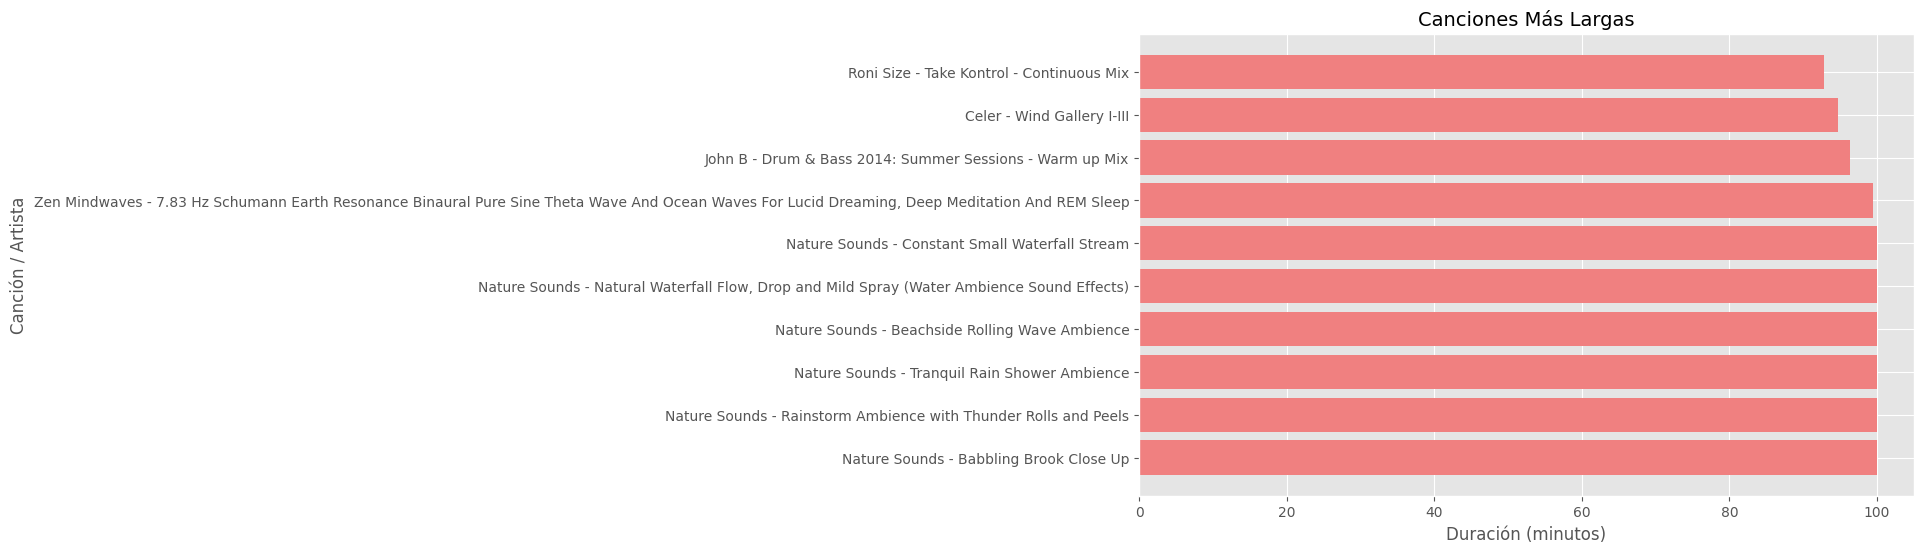

In [74]:
provider = ElasticSearchProvider()
response = provider.showMoreLongSongs()
if response:
    # Convertir la duración de milisegundos a minutos
    track_names = [f"{hit['_source']['artist_name']} - {hit['_source']['track_name']}" for hit in response['hits']['hits']]
    durations = [hit['_source']['duration_ms'] / 60000 for hit in response['hits']['hits']]  # Convertir a minutos

    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.barh(track_names, durations, color='lightcoral')

    # Añadir título y etiquetas
    plt.title('Canciones Más Largas', fontsize=14)
    plt.xlabel('Duración (minutos)', fontsize=12)
    plt.ylabel('Canción / Artista', fontsize=12)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()
else:
    print("No se obtuvo respuesta válida.")